In [1]:
#importing necessary packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.api import abline_plot
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import linear_model, preprocessing
import warnings

First thing we need to do is load the data from our cleaning process:

In [2]:
songs = pd.read_csv('../data/songs_data_cleaned.csv')
songs.head()
songs.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [3]:
songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682853 entries, 0 to 682852
Data columns (total 28 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   spotify_id          682853 non-null  object 
 1   name                682853 non-null  object 
 2   artists             682853 non-null  object 
 3   daily_rank          682853 non-null  int64  
 4   daily_movement      682853 non-null  int64  
 5   weekly_movement     682853 non-null  int64  
 6   country             682853 non-null  object 
 7   snapshot_date       682853 non-null  object 
 8   popularity          682853 non-null  int64  
 9   is_explicit         682853 non-null  bool   
 10  duration_ms         682853 non-null  int64  
 11  album_name          682853 non-null  object 
 12  album_release_date  682853 non-null  object 
 13  danceability        682853 non-null  float64
 14  energy              682853 non-null  float64
 15  key                 682853 non-nul

One of the first things we need to do is convert the dates to date formats:

In [4]:
songs['snapshot_date'] = pd.to_datetime(songs['snapshot_date'])
songs['album_release_date'] = pd.to_datetime(songs['album_release_date'])
songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682853 entries, 0 to 682852
Data columns (total 28 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   spotify_id          682853 non-null  object        
 1   name                682853 non-null  object        
 2   artists             682853 non-null  object        
 3   daily_rank          682853 non-null  int64         
 4   daily_movement      682853 non-null  int64         
 5   weekly_movement     682853 non-null  int64         
 6   country             682853 non-null  object        
 7   snapshot_date       682853 non-null  datetime64[ns]
 8   popularity          682853 non-null  int64         
 9   is_explicit         682853 non-null  bool          
 10  duration_ms         682853 non-null  int64         
 11  album_name          682853 non-null  object        
 12  album_release_date  682853 non-null  datetime64[ns]
 13  danceability        682853 no

This dataset contains a song in a country on a specific day. The type of data can be broken down by:


**Song Identification**
- song ID
- name
- artist
- Album name
- Album release date

**Country Identification**
- Country
- GDP
- CPI

**Date Identification**
- Date

**Popularity Indicators (at country/date specific)**
- Daily rank
- Daily movement
- Weekly movement
- Popularity
- Top5 indicator

**Song Specific Characteristics**
- Is explicit?
- Duration
- Danceability
- Energy
- Key
- Loudness
- Mode
- Speechiness
- Acousticness
- Instrumentalness
- Liveness
- Valence
- Tempo
- Time Signature

The final goal is to predict wether a song will make it to the top 5 at a specific country (given the characteristics of the song). The first thing we want to look at is the spread of the **Daily Rank** and the ditribution, as well as the values that are considering top5:

<Axes: xlabel='daily_rank', ylabel='Count'>

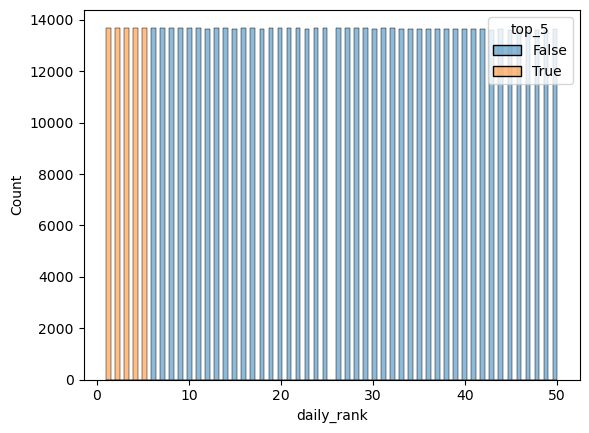

In [5]:
sns.histplot(x = 'daily_rank', hue='top_5', data = songs, bins = 100)

This is a good sign as it shows our data includes data whitin all ranges of the 'daily rank'. We could consider this entire data set as the whole universe of songs. We can also see that the variable to predict "top_5" is only the cases where the daily rank is 1-5. With this in mind, we can use daily_rank as a potential predictor for this exercise.

Next we should look at the correlations between our potential "variables" with each other as well as with the ranking. to identify which would potentially be the best to explain our data.

One thing to call out is that the "Country" is a text value and as it is we cannot use it to calculate a correlation with the other variables. for now we will use country specific information (like GDP and CPI) to test for correlation.

The first thing we need to do is create a subset of our main dataset, including only numerical variables:

In [6]:
songs_nm = songs.loc[: , songs.dtypes != 'object']

In [7]:
#Review the correlation matrix
songs_nm.corr()

,daily_rank,daily_movement,weekly_movement,snapshot_date,popularity,is_explicit,duration_ms,album_release_date,danceability,energy,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,top_5,GDP,CPI
daily_rank,1.000000,-0.149202,-0.269887,0.000270,-0.099229,-0.029880,0.047838,-0.046121,-0.047597,-0.022286,...,0.012304,0.011648,0.016339,0.024545,-0.038208,-0.003479,0.061608,-0.519869,-0.002910,0.000073
daily_movement,-0.149202,1.000000,0.287413,0.021845,-0.187265,-0.004551,0.004008,-0.018813,-0.013978,-0.005534,...,0.001013,-0.001340,0.003051,0.001299,-0.004283,-0.000649,0.002608,0.059183,0.024383,0.003450
weekly_movement,-0.269887,0.287413,1.000000,-0.081593,-0.183003,-0.006177,0.000651,-0.046761,-0.026789,-0.007200,...,0.007735,-0.006422,0.000358,0.007425,-0.002870,0.001753,0.006256,0.121212,0.052510,-0.002556
snapshot_date,0.000270,0.021845,-0.081593,1.000000,-0.028773,-0.006626,-0.020356,0.095379,0.001540,0.036384,...,-0.023656,-0.052507,-0.009575,-0.002136,-0.005691,0.009956,-0.008680,0.000056,-0.004805,-0.003638
popularity,-0.099229,-0.187265,-0.183003,-0.028773,1.000000,0.112693,-0.019150,-0.078185,-0.016299,0.045091,...,-0.135694,-0.054992,-0.040645,-0.011250,0.004758,0.002171,-0.135419,0.077412,0.079320,0.050143
is_explicit,-0.029880,-0.004551,-0.006177,-0.006626,0.112693,1.000000,-0.058646,0.164003,0.317191,0.148163,...,0.292449,-0.180736,-0.024454,0.005786,0.002696,0.025974,-0.061120,0.020021,-0.050595,0.060581
duration_ms,0.047838,0.004008,0.000651,-0.020356,-0.019150,-0.058646,1.000000,-0.025824,-0.215096,-0.062872,...,-0.055447,-0.001035,-0.002775,0.018140,-0.188643,-0.027250,0.107412,-0.019301,-0.014638,0.002007
album_release_date,-0.046121,-0.018813,-0.046761,0.095379,-0.078185,0.164003,-0.025824,1.000000,0.198317,0.144308,...,0.123950,-0.147736,0.006528,-0.014730,-0.081324,0.016315,0.005033,0.032753,-0.136579,0.018143
danceability,-0.047597,-0.013978,-0.026789,0.001540,-0.016299,0.317191,-0.215096,0.198317,1.000000,0.248515,...,0.218804,-0.279734,-0.033774,-0.131559,0.377327,-0.165244,0.065252,0.043362,-0.199578,0.065761
energy,-0.022286,-0.005534,-0.007200,0.036384,0.045091,0.148163,-0.062872,0.144308,0.248515,1.000000,...,0.046598,-0.558701,-0.031061,0.132806,0.337668,0.108530,0.030541,0.035723,-0.079747,0.031394


<Axes: >

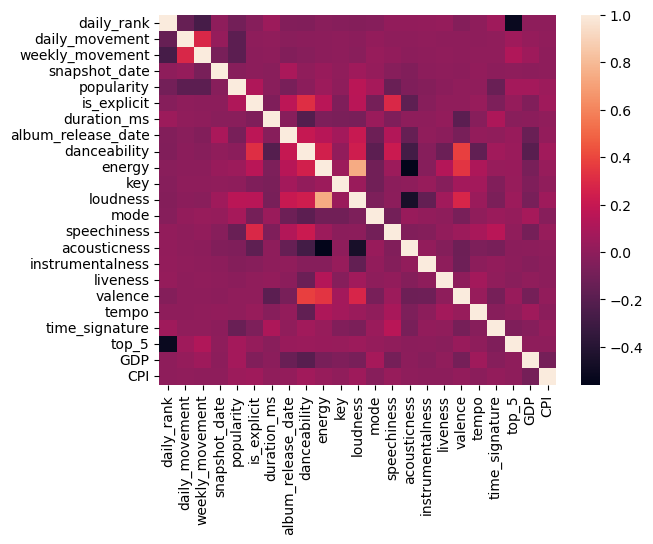

In [8]:
#create the heatmap of the correlation:
sns.heatmap(songs_nm.corr())

From these results, the only correlation that could be concerning is the energy vs loudness with a pearson coef of 0.74 it seems to have high correlation. Lets revise this correlation in more detail before making a decision:

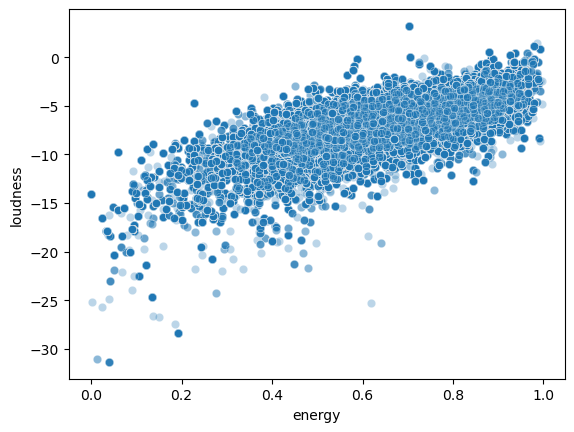

In [9]:
# Plot energy against loudness
sns.scatterplot(x='energy', y='loudness',alpha = 0.3, data = songs)
plt.show()

It looks like there is a fairly stron and positive correlation between the loudness and the energy of the song. based on this result, <span style="background-color: #FFFF00"> we will be dropping the loudness column and keeping only energy. </span> <br>

The next thing we want to do is identify potential correlations within the existing data and the variable we are trying to predict. Before we can continue analyzing, since our data is so large and we want to be able to predict at country level, the first thing we are going to do is pick a couple of countries based on the average number of days a song remains in the top 5:

To do this we will create a function to plot 2 variables and use the color to identify wether these are top5 or not. We will do this for all the variables that could potentially describe the data:

In [64]:
# group the songs by the number of days on top 5 at each country to calculate the songs per country with the number of days in top 5
songsbycountry = pd.DataFrame(songs.groupby(['spotify_id', 'country'])['top_5'].sum().sort_values()).reset_index()

<Axes: xlabel='country', ylabel='top_5'>

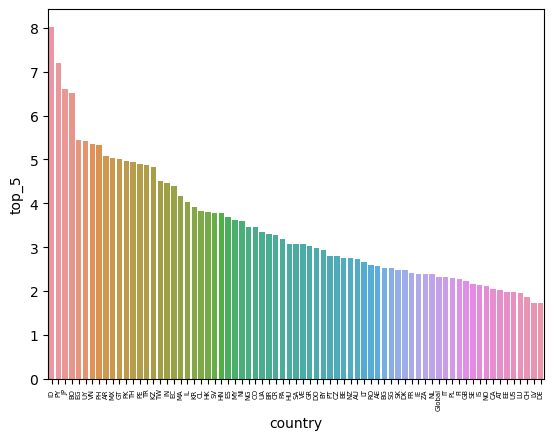

In [106]:
plt.xticks(rotation = 90, fontsize = 5)
sns.barplot(songsbycountry, x = 'country', y = 'top_5', estimator = 'mean', errorbar = None, order = songsbycountry.groupby('country')['top_5'].mean().sort_values(ascending = False).index)


In [108]:
countriesToReview = ['ID', 'PY', 'LV', 'DE']

It looks like ID and PY are the countries where songs remain on average the longest time on top_5, in contrast it looks like LV and DE are the countries where the songs remain the least amount of time on top_5. Lets use these 4 countries to review the behaviour and correlation of data.


In [143]:
res = pd.DataFrame(columns = [ 'daily_rank', 'daily_movement', 'weekly_movement', 'snapshot_date',
       'popularity', 'is_explicit', 'duration_ms', 'album_release_date',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'time_signature', 'top_5', 'GDP', 'CPI', 'country'])
for c in countriesToReview:
    songs_nm = songs.loc[songs['country']==c ,  songs.dtypes != 'object']
    temp = pd.DataFrame(songs_nm.corr()['daily_rank']).T
    temp['country'] = c
    res = pd.concat([res, temp], ignore_index = True)
print(res)

   daily_rank  daily_movement  weekly_movement  snapshot_date  popularity  \
0         1.0       -0.113192        -0.216315      -0.000719   -0.162900   
1         1.0       -0.107793        -0.184911      -0.000293   -0.315731   
2         1.0       -0.171590        -0.281844       0.000429   -0.108818   
3         1.0       -0.193038        -0.342505      -0.000221   -0.146784   

   is_explicit  duration_ms  album_release_date  danceability    energy  ...  \
0     0.116460     0.075039           -0.198145     -0.065084  0.028053  ...   
1    -0.070868     0.087320           -0.008746     -0.093667 -0.143574  ...   
2    -0.034191     0.145136           -0.049128     -0.009951  0.023527  ...   
3    -0.019038     0.061134            0.049461      0.004226  0.011164  ...   

   acousticness  instrumentalness  liveness   valence     tempo  \
0     -0.061490          0.067104 -0.011224  0.118324 -0.043321   
1     -0.033790          0.085451  0.024561 -0.002977  0.047361   
2     -0.030

From the results, we are seeing that different countries in fact seem to have different appreciation for music characteristics:
**popularity:** which seems to influence the daily rank of a song 3X more in paraguay than the other 3 countries.
**explicit:** explicit songs seem to perform much better in countries where they last longer at the top_5.
**duration:** longer duration songs are more likely to be correlated with teh daily rank in Latvia than the other 3 countries.
**tempo:** tempo seems to have stronger correlation to daily rank in latvia than the other countries.

Before we continue, lets start looking at the influence of these variables visually. to do this the first thing we will do is create a function to plot 2 variables and use the color to identify wether these are top5 or not, and then use it to see some of the influence on these countries:

In [173]:
def plt2(y):
    plt.close()
    sns.relplot(x='daily_rank', y=y, kind = 'scatter', hue='top_5', alpha = 0.2, data = songs[songs['country'].isin(countriesToReview)], col = 'country')

/Users/alfredohernandez/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


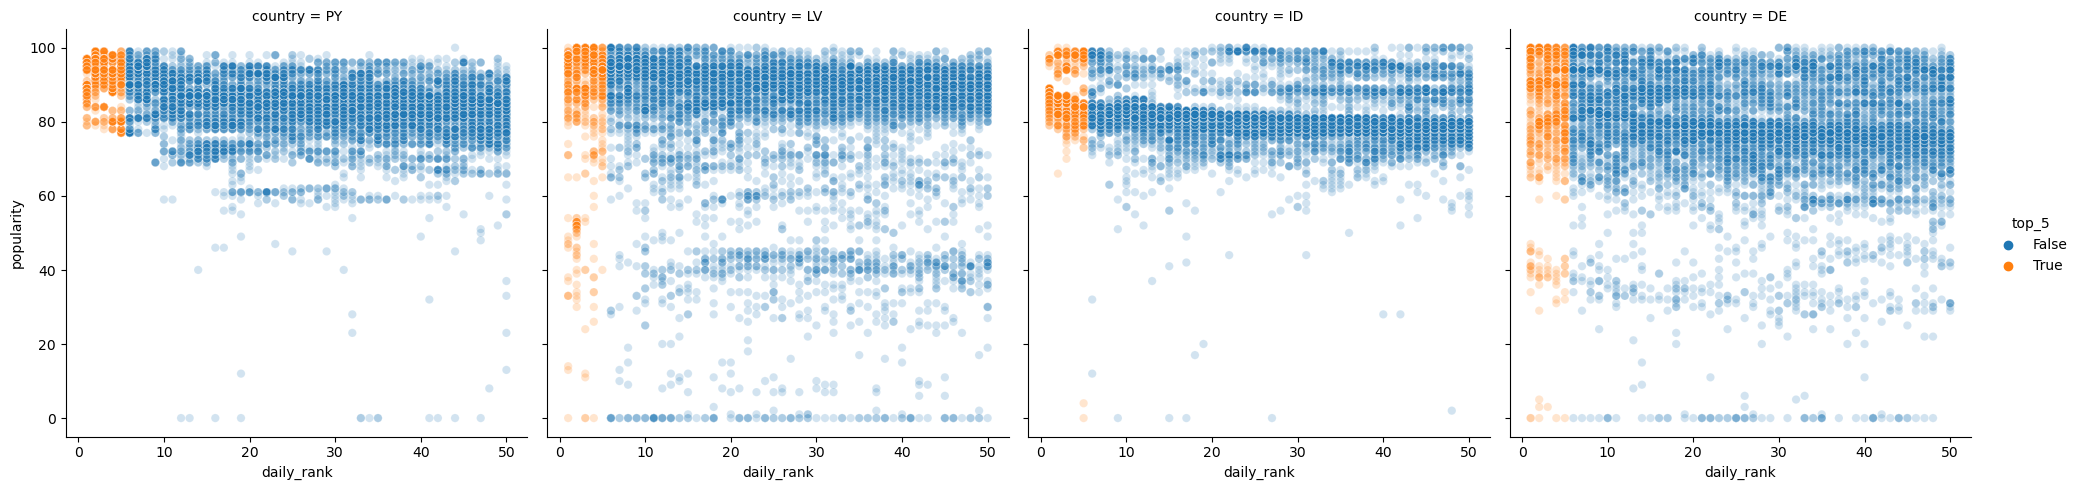

In [174]:
plt2('popularity')

By looking at popularity vs daily ranks, we can see that for countries like Paraguay and Indonesia, the popularity is usually over 80 for top_5 songs and slowly decreases as the ranking is higher. on the other hand, we see the other 2 countries (Latvia and Germany) to have the top_5 songs spread across different popularity and a much lower correlation between popularity and daily rank.

Next lets take a look at the impact on is_explicit:

/Users/alfredohernandez/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


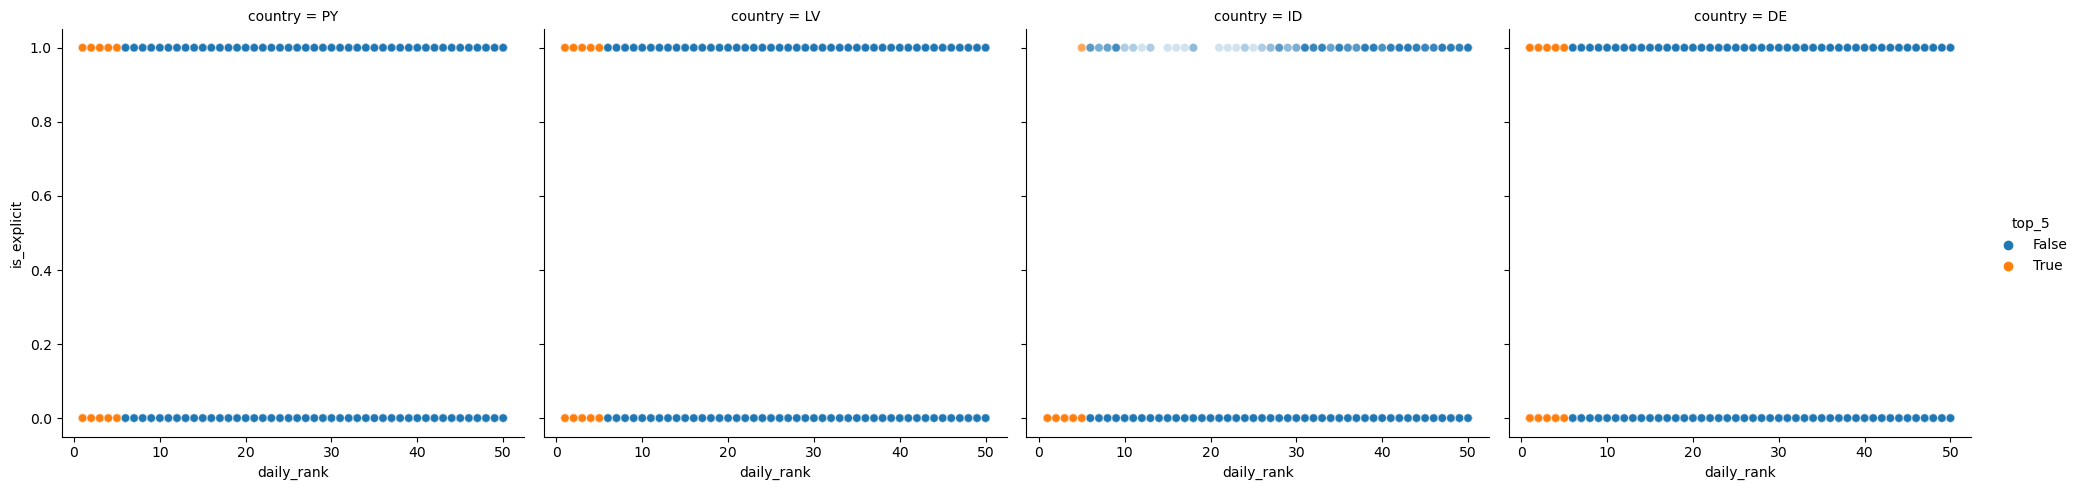

In [175]:
plt2('is_explicit')

From what we can see, it looks like explicit songs perform somewhat equally at most countries but Indonesia. It looks that explicit songs rarely make it to the top_5 and when they do they usually never make it higher than 5.

We will next do this analysis for duration:

/Users/alfredohernandez/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


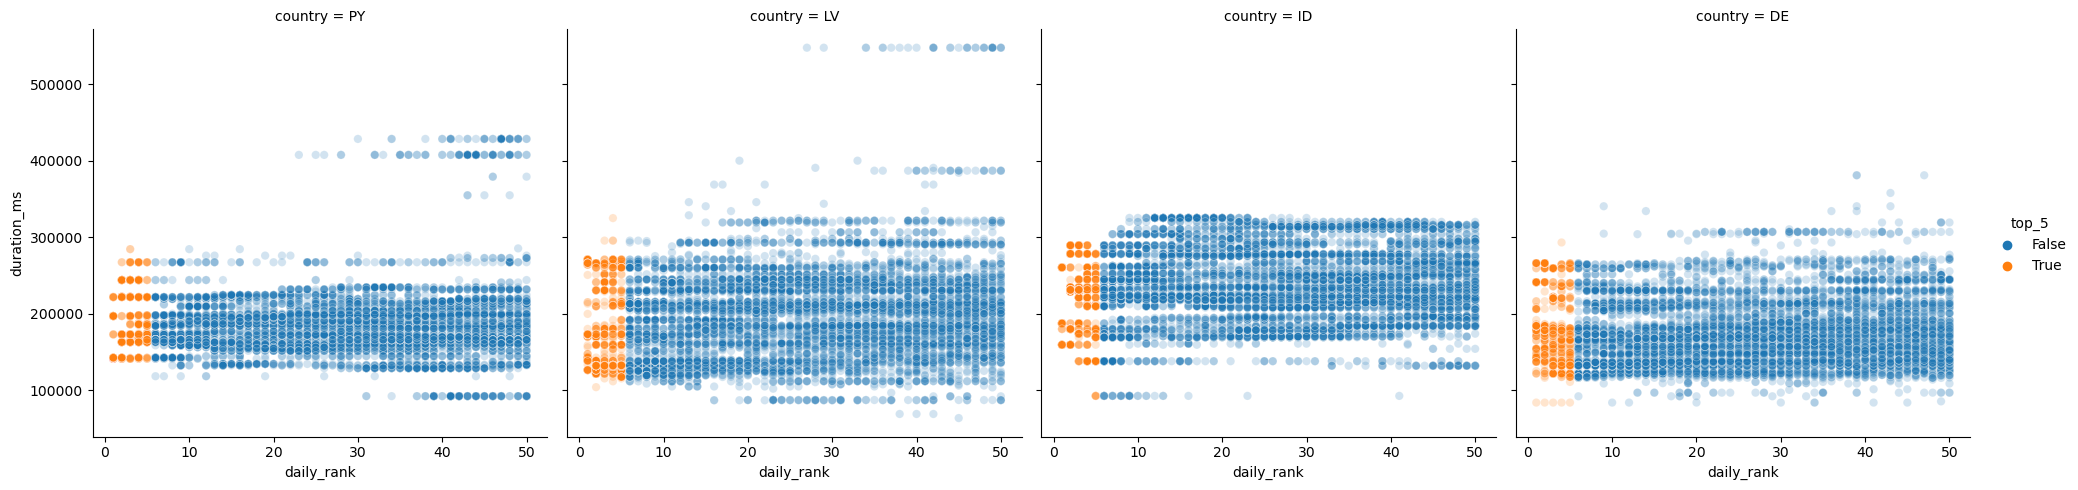

In [176]:
plt2('duration_ms')

Duration also gives us a clear picture for the differences in these countries. it looks like in general top_5 songs are longer than 150K ms and shorter than 300K ms (2.5 to 5 minutes long). However, when we look at the whole top_50 songs, we can see that the spread around the 3.3 minute mark is wider or narrower depending on the country and particularly for Indonesia, songs in the top50 are closely capped at a bit over 5 minutes. 

/Users/alfredohernandez/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


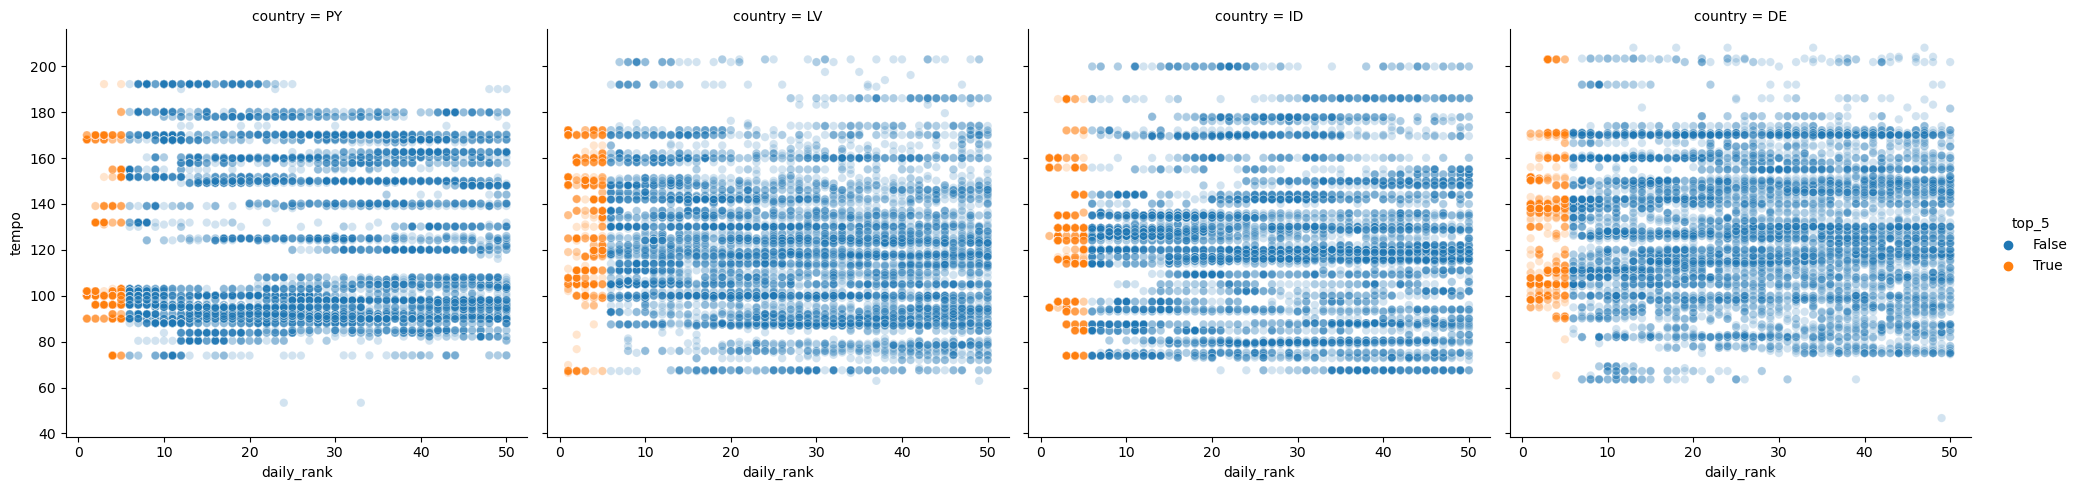

In [177]:
plt2('tempo')

Regarding tempo, once again the preferred tempo driving the top_5 and top_50 varies between countries. it is notable that Latvia seems to have the smallest interval of preferred tempo for their top_5 songs whole there seems to be a preference for slower tempo songs at Paraguay vs Germany.
One interesting fact is that Paraguay seems to have bands of tempo where no song seems to fall in (for the whole top_50) like 120 or 145. This could be an interesting deep dive. 

One of the things that mostly jumped from our previous analysis was the fact that explicit songs seem to perform overall lower in Indonesia than other countries. To test this, we will run a statistical analysis on wether there is an actual difference in the performance.


In [180]:
songs.columns

Index(['spotify_id', 'name', 'artists', 'daily_rank', 'daily_movement',
       'weekly_movement', 'country', 'snapshot_date', 'popularity',
       'is_explicit', 'duration_ms', 'album_name', 'album_release_date',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'time_signature', 'top_5', 'GDP', 'CPI'],
      dtype='object')

In [192]:
def sampler(data, n):
    return np.random.choice(data, n)

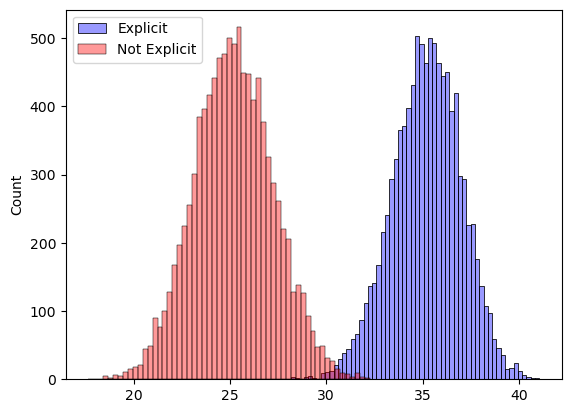

In [217]:
samples = np.empty(10000)
id_e = songs[(songs['country'] == 'ID') & (songs['is_explicit'] == True)]['daily_rank']
for i in range(len(samples)):
    samples[i] = sampler(id_e, 50).mean()

samples2 = np.empty(10000)
id_ne = songs[(songs['country'] == 'ID') & (songs['is_explicit'] == False)]['daily_rank']
for i in range(len(samples2)):
    samples2[i] = sampler(id_ne, 50).mean()

sns.histplot(samples, color = 'b', alpha=0.4)
sns.histplot(samples2, color = 'r', alpha = 0.4)
plt.legend(['Explicit', 'Not Explicit'])

In [218]:
from scipy import stats

stats.ttest_ind(id_e, id_ne)

TtestResult(statistic=11.401150586763327, pvalue=6.468437881897062e-30, df=9454.0)

As we can see above. The average ranking of 50 songs seem to have different distributions (for Indonesia) as the distribution of the average ranking are around 25 for not explicit songs but it goes to 35 for explicit songs. 

When running a T test to test the null hypothesis that the average ranking of songs is independent for explict and not explicit songs in Indonesia. The result is a p-value close to 0, which means we can refuse the null hypothesis and confirm that wether a sont is or not explicit has an impact on the overall ranking of the song for Indonesia.

Lets build a useful function to test and view the difference in the top_5 songs at a given country:

In [227]:
def test_variable(country, variable):
    samples = np.empty(10000)
    samples2 = np.empty(10000)
    sng_on = songs[(songs['country'] == country) & (songs['top_5'] == True)][variable]
    sng_off = songs[(songs['country'] == country) & (songs['top_5'] == False)][variable]
    for i in range(len(samples)):
        samples[i] = sampler(sng_on, 50).mean()


    for i in range(len(samples2)):
        samples2[i] = sampler(sng_off, 50).mean()

    sns.histplot(samples, color = 'b', alpha=0.4)
    sns.histplot(samples2, color = 'r', alpha = 0.4)
    plt.legend(['Top_5', 'Not_Top_5'])
    
    print(stats.ttest_ind(sng_on, sng_off))

TtestResult(statistic=5.186773749201466, pvalue=2.1840069243821897e-07, df=9454.0)


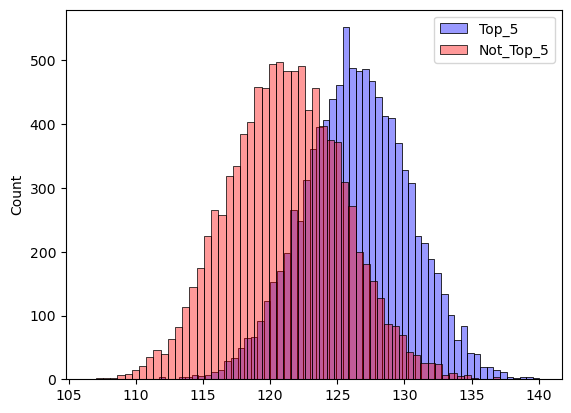

In [228]:
test_variable('ID', 'tempo')

We can see that for Indonesia, the tempo is overall diferent for top_5 and not top_5 songs and using a t-statist test we can confirm that the average tempo for top_5 songs is higher than not top_5 songs. This results seem to be replicated at our other 3 countries:

TtestResult(statistic=2.5767069995074965, pvalue=0.009989893002991464, df=9316.0)


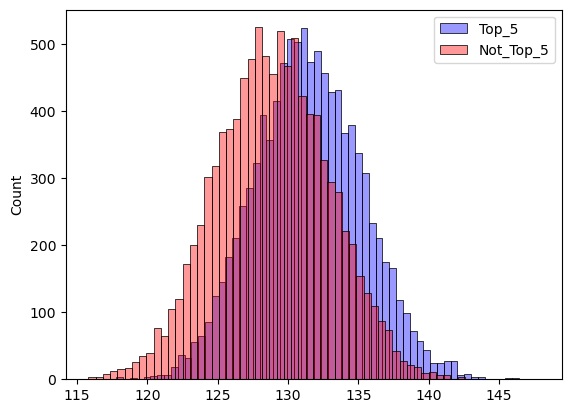

In [229]:
test_variable('DE', 'tempo')

TtestResult(statistic=-7.857091719541391, pvalue=4.370468550521221e-15, df=9251.0)


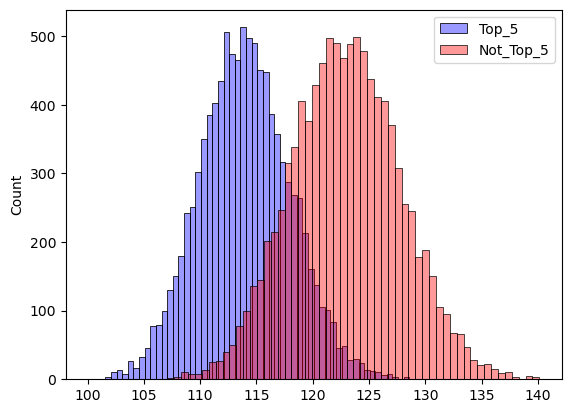

In [230]:
test_variable('PY', 'tempo')

TtestResult(statistic=13.882282508801492, pvalue=2.2008768454902194e-43, df=9271.0)


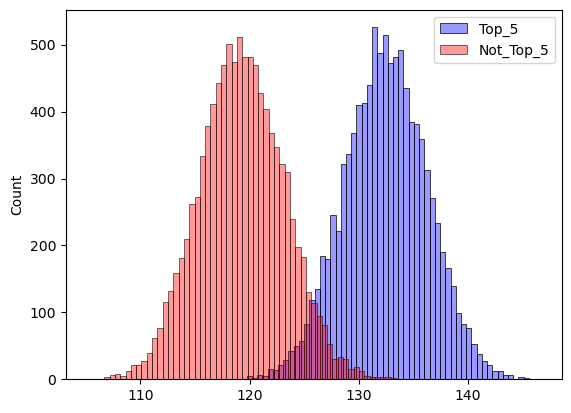

In [231]:
test_variable('LV', 'tempo')

These results are promising as it looks like there is enough evidence to believe that tempo as well as explicit content makes a difference in the overall performance of a song based on the country as well as the chances of it being in the top5. It looks like we can use the variables Is explicit, Duration, Danceability, Energy, Key, Loudness, Mode, Speechiness, Acousticness, Instrumentalness, Liveness, Valence, Tempo and Time Signature to try and predict the likelihood of a song making it to the top 5 in a specifc country.
As part of our final step before moving on form our EDA, we will encode our country variable to include it in our modelling:

In [233]:
songs['country'].unique()

array(['Global', 'ZA', 'VN', 'VE', 'UY', 'US', 'UA', 'TW', 'TR', 'TH',
       'SV', 'SK', 'SG', 'SE', 'SA', 'RO', 'PY', 'PT', 'PL', 'PK', 'PH',
       'PE', 'PA', 'NZ', 'NO', 'NL', 'NI', 'NG', 'MY', 'MX', 'MA', 'LV',
       'LU', 'LT', 'KZ', 'KR', 'JP', 'IT', 'IS', 'IN', 'IL', 'IE', 'ID',
       'HU', 'HN', 'HK', 'GT', 'GR', 'GB', 'FR', 'FI', 'ES', 'EG', 'EE',
       'EC', 'DO', 'DK', 'DE', 'CZ', 'CR', 'CO', 'CL', 'CH', 'CA', 'BY',
       'BR', 'BO', 'BG', 'BE', 'AU', 'AT', 'AR', 'AE'], dtype=object)

In [234]:
#create the encoder
encoder = preprocessing.OneHotEncoder(drop = None, handle_unknown='error')

In [235]:
#fit it to our country column
x_encoded = encoder.fit_transform(np.reshape(songs['country'], (-1,1)))

In [236]:
country_encoded = pd.DataFrame.sparse.from_spmatrix(x_encoded, columns=encoder.categories_)

In [237]:
songs_encoded = songs.join(country_encoded)

In [238]:
songs_encoded.columns                                

Index([     'spotify_id',            'name',         'artists',
            'daily_rank',  'daily_movement', 'weekly_movement',
               'country',   'snapshot_date',      'popularity',
           'is_explicit',
       ...
                 ('SV',),           ('TH',),           ('TR',),
                 ('TW',),           ('UA',),           ('US',),
                 ('UY',),           ('VE',),           ('VN',),
                 ('ZA',)],
      dtype='object', length=101)